<a href="https://colab.research.google.com/github/maryamyazdi/clustering_climbers_data/blob/master/clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

#Read data from the source
primary_data = pd.read_csv('./climbers.csv', index_col=False)
primary_data.head()

,Power(watts),Distance(metres),Heartrate(BPM),Speed(m/s),WindSpeed (m/s),Cadaence(revs/s),Elevation(meters),Hill slope(%),Temperature(C),Cluster
0,0.0,0.000,57.0,1.4305,1.6093,0.0,55.778,-2.85,25.556,C
1,0.0,0.000,57.0,1.6540,2.9505,0.0,55.778,-4.40,25.556,C
2,0.0,0.000,57.0,2.5034,3.1740,0.0,55.778,-5.85,25.556,C
3,0.0,16.093,61.0,2.5034,3.8445,0.0,55.778,-6.30,25.556,C
4,0.0,16.093,62.0,2.5481,3.2187,0.0,55.778,-5.62,25.556,C


In [2]:
primary_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4435 entries, 0 to 4434
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Power(watts)       4433 non-null   float64
 1   Distance(metres)   4432 non-null   float64
 2   Heartrate(BPM)     4430 non-null   float64
 3   Speed(m/s)         4430 non-null   float64
 4   WindSpeed (m/s)    4417 non-null   float64
 5   Cadaence(revs/s)   4431 non-null   float64
 6   Elevation(meters)  4434 non-null   float64
 7   Hill slope(%)      4433 non-null   float64
 8   Temperature(C)     4433 non-null   float64
 9   Cluster            4435 non-null   object 
dtypes: float64(9), object(1)
memory usage: 346.6+ KB


In [3]:
#Drop the 'Cluster' column to get unlabeled data
data = primary_data.drop('Cluster', axis=1)

In [4]:
#EDA
#Get some statistical information
data.describe()

,Power(watts),Distance(metres),Heartrate(BPM),Speed(m/s),WindSpeed (m/s),Cadaence(revs/s),Elevation(meters),Hill slope(%),Temperature(C)
count,4433.000000,4432.000000,4430.000000,4430.000000,4417.000000,4431.000000,4434.000000,4433.000000,4433.000000
mean,203.280929,13299.428148,134.679233,6.908460,28.913162,1.057530,297.477890,6.236253,67.067109
std,226.608316,8852.280875,190.467867,3.867753,1504.565864,0.454244,204.280334,195.328918,3003.560286
min,-5000.100000,-50000.000000,-5000.000000,0.000000,0.000000,0.000000,48.158000,-14.080000,-273.000000
25%,132.530000,7065.000000,123.000000,3.352800,2.548100,0.900000,78.334000,-1.530000,20.556000
50%,229.830000,11040.000000,142.000000,5.900900,5.364500,1.150000,290.170000,2.310000,22.222000
75%,289.740000,20620.000000,166.000000,9.656000,9.164300,1.383300,508.410000,9.440000,24.444000
max,889.670000,30626.000000,174.000000,17.926000,100000.000000,2.266700,628.500000,13000.000000,200000.000000


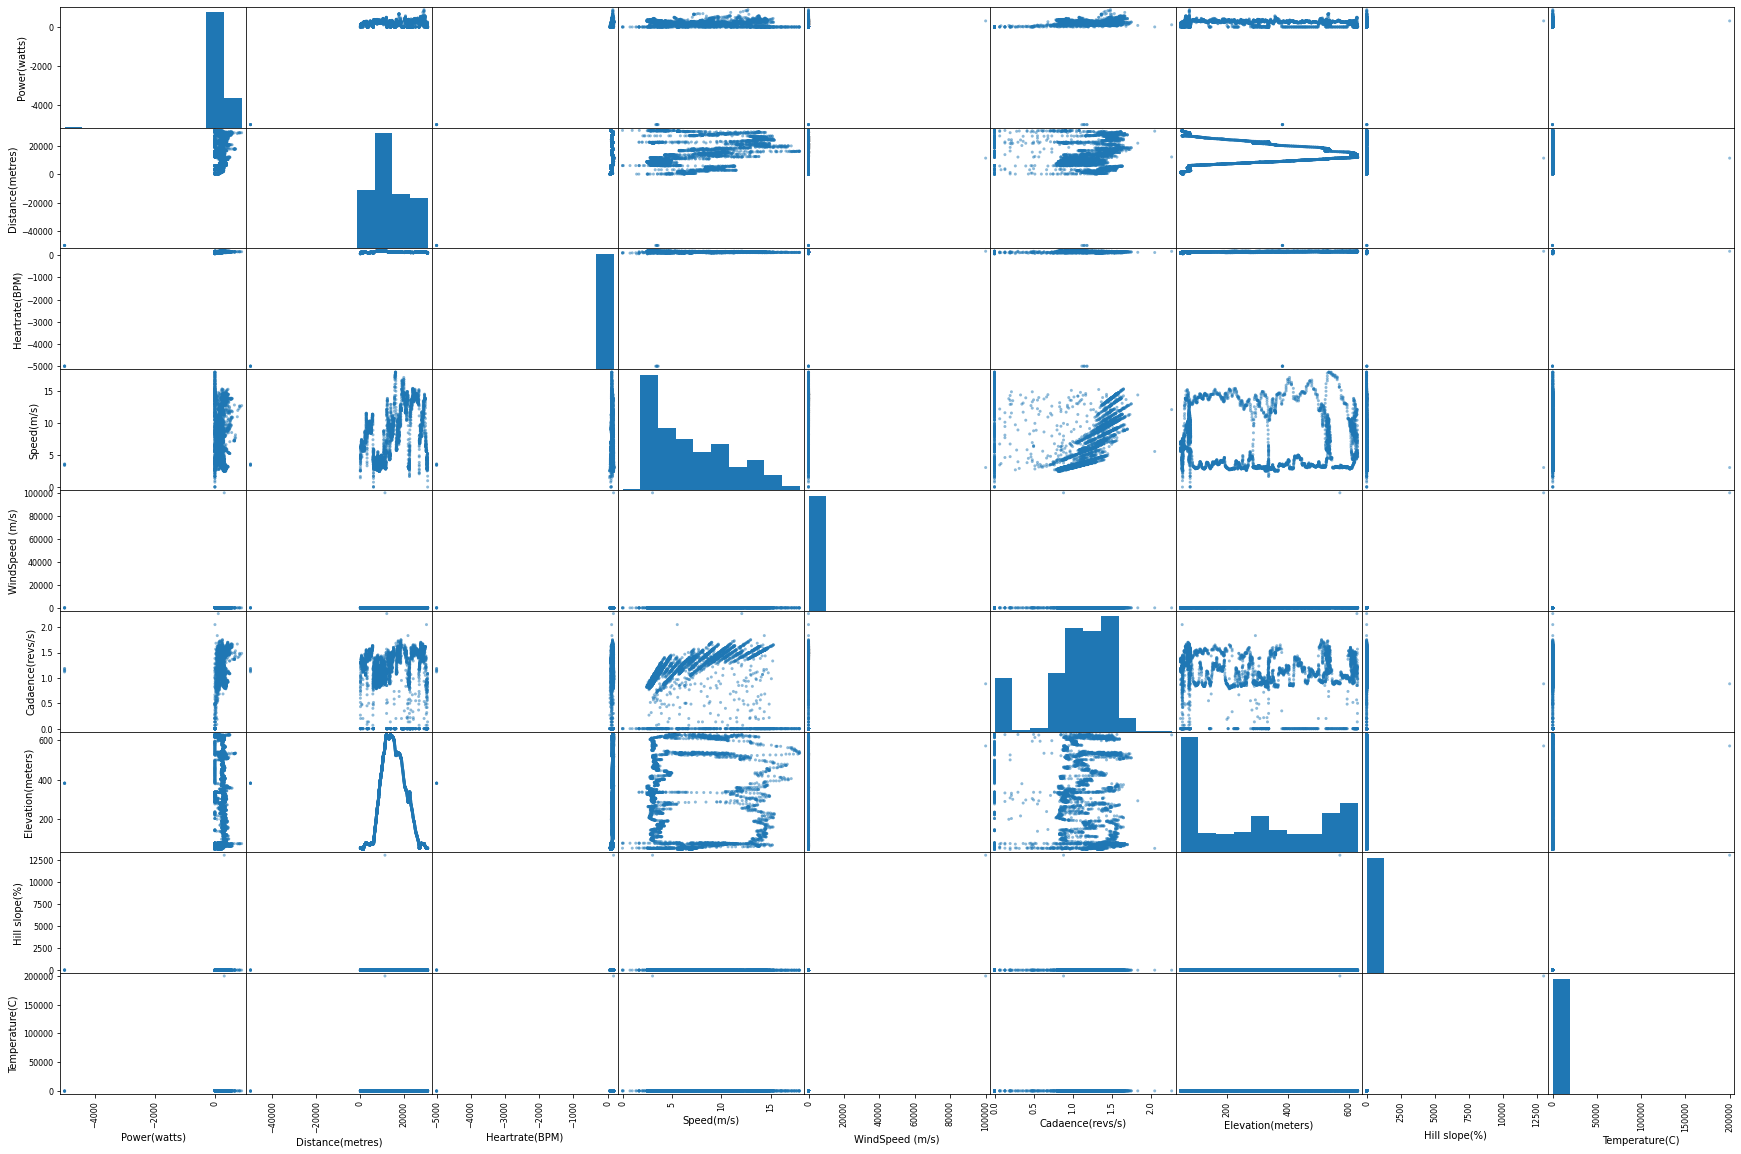

In [5]:
#Get an overall view of pairwise relationships between columns
scatter_matrix(data, figsize=(30,20))
plt.show()

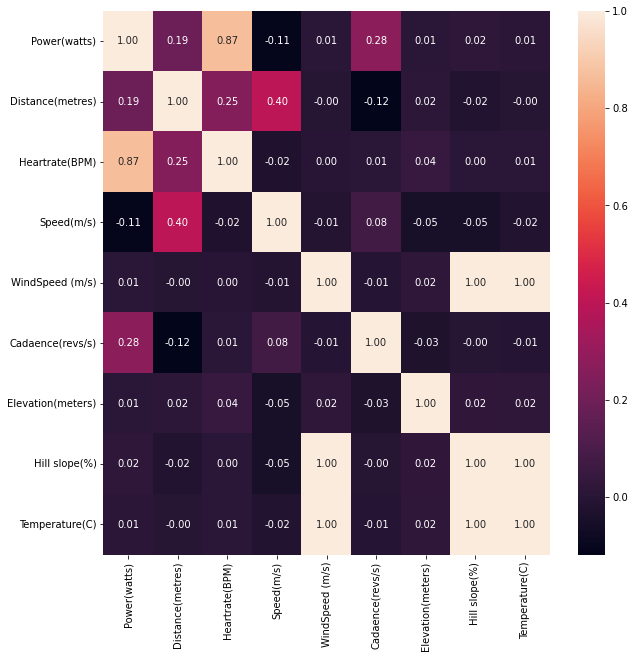

In [6]:
#Plot a heatmap to visualize density and find data cohesion
corr_matrix = data.corr()

fig, ax = plt.subplots(figsize=(10, 10))
sbn.heatmap(corr_matrix, ax=ax, annot=True, fmt='.2f')
plt.show()

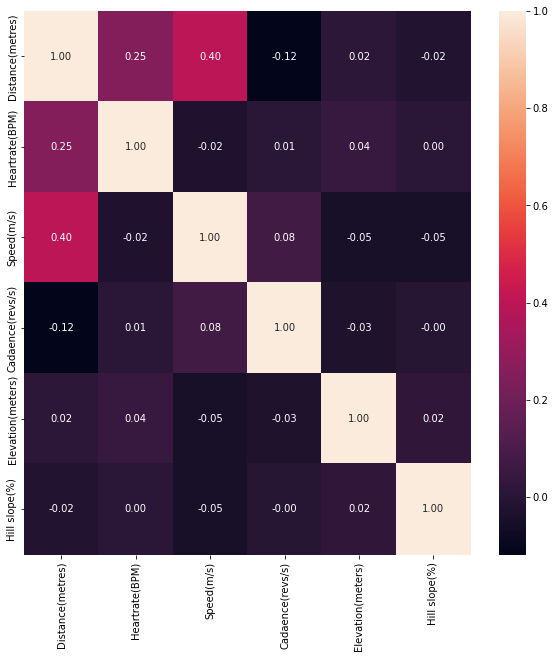

In [7]:
#Remove redundant columns (implying each other) based on hot spots in heatmap
removed_redundant_data = data.drop(columns=['WindSpeed (m/s)', 'Temperature(C)', 'Power(watts)'])

corr_matrix = removed_redundant_data.corr()

fig, ax = plt.subplots(figsize=(10, 10))
sbn.heatmap(corr_matrix, ax=ax, annot=True, fmt='.2f')
plt.show()

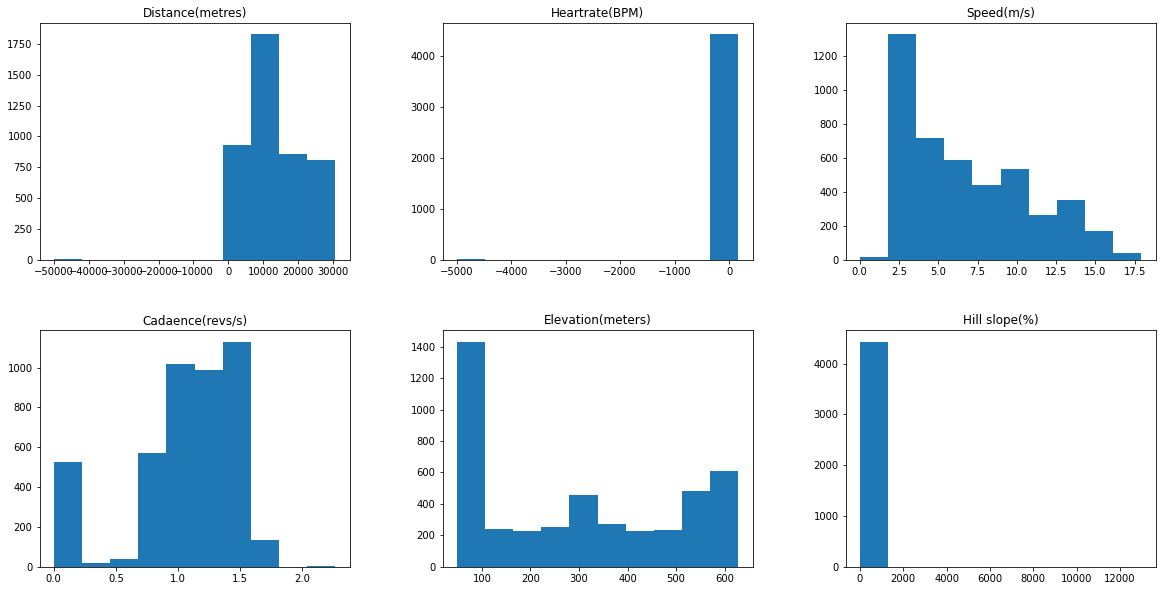

In [8]:
#Get a view of each column distribution by its histogram
pd.plotting.hist_frame(removed_redundant_data, figsize=(20, 10), edgecolor='none', grid=False, layout=(2, 3))
plt.show()

In [9]:
def fix_outliers(col, fixed_value):
    """
    Find and replace the outliers in ``col``.

    The non-normal distribution illustrated in the previous histograms was
    due to outliers. This function catches the outliers with IQR method and
    replace them with ``fixed-value``.

    Parameters
    ----------
    col : Series
        The certain column to fix its outliers.
    fixed_value : float
        The replacing value to outliers.

    Returns
    -------
    Series
        The given column ``col`` but the outliers replaced by ``fixed-value``.
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    outlier_condition = (col < (Q1 - 1.5 * IQR)) | (col > (Q3 + 1.5 * IQR))
    col.loc[outlier_condition, ] = fixed_value
    return col

removed_outliers_data = removed_redundant_data

#Replace outliers in three most non-normal distributed columns
#Use median because mean is mostly effected by outliers
removed_outliers_data['Distance(metres)'] = fix_outliers(removed_redundant_data['Distance(metres)'], removed_redundant_data['Distance(metres)'].median())
removed_outliers_data['Heartrate(BPM)'] = fix_outliers(removed_redundant_data['Heartrate(BPM)'], removed_redundant_data['Heartrate(BPM)'].median())
removed_outliers_data['Hill slope(%)'] = fix_outliers(removed_redundant_data['Hill slope(%)'], removed_redundant_data['Hill slope(%)'].median())

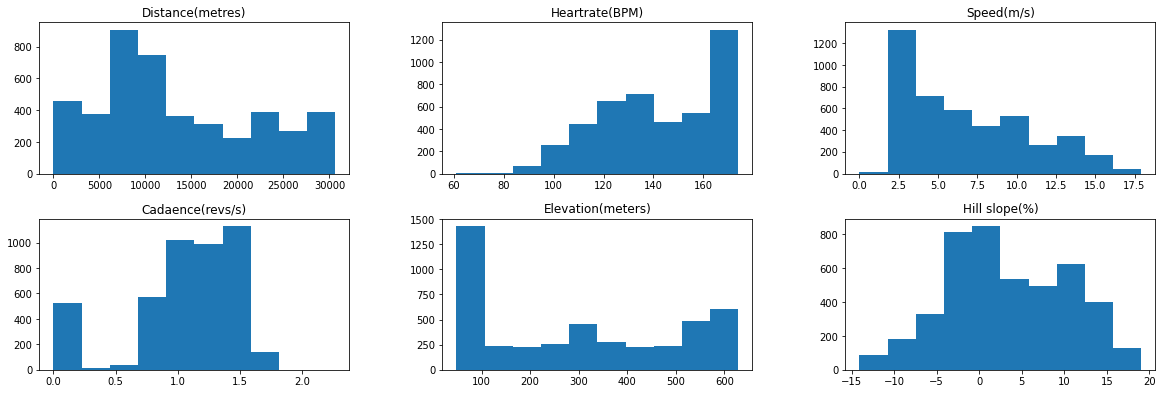

In [10]:
pd.plotting.hist_frame(removed_outliers_data, figsize=(20, 10), edgecolor='none', grid=False, layout=(3, 3))
plt.show()

In [11]:
primary_data.isnull().sum()

Power(watts)          2
Distance(metres)      3
Heartrate(BPM)        5
Speed(m/s)            5
WindSpeed (m/s)      18
Cadaence(revs/s)      4
Elevation(meters)     1
Hill slope(%)         2
Temperature(C)        2
Cluster               0
dtype: int64

In [12]:
#Fill the missing values
removed_outliers_data.fillna(removed_outliers_data.median(), inplace=True)
removed_outliers_data.isnull().sum()

Distance(metres)     0
Heartrate(BPM)       0
Speed(m/s)           0
Cadaence(revs/s)     0
Elevation(meters)    0
Hill slope(%)        0
dtype: int64

In [13]:
#Scale the data in range of 0 to 1
scaler = MinMaxScaler()

cleaned_data = pd.DataFrame(scaler.fit_transform(removed_outliers_data), columns=removed_outliers_data.columns)

cleaned_data

,Distance(metres),Heartrate(BPM),Speed(m/s),Cadaence(revs/s),Elevation(meters),Hill slope(%)
0,0.000000,0.716814,0.079800,0.0,0.01313,0.339172
1,0.000000,0.716814,0.092268,0.0,0.01313,0.292359
2,0.000000,0.716814,0.139652,0.0,0.01313,0.248565
3,0.000525,0.000000,0.139652,0.0,0.01313,0.234974
4,0.000525,0.008850,0.142145,0.0,0.01313,0.255512
...,...,...,...,...,...,...
4430,0.999478,0.345133,0.169580,0.0,0.01103,0.389006
4431,1.000000,0.345133,0.144639,0.0,0.01103,0.371791
4432,1.000000,0.345133,0.094762,0.0,0.01103,0.386288
4433,1.000000,0.336283,0.054864,0.0,0.01103,0.427967


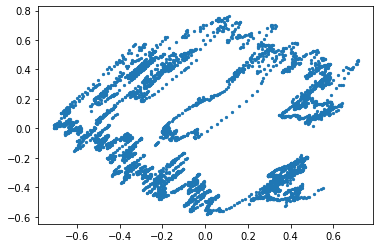

In [14]:
#Visualize the data reducing dimensions to two
#See close data points belong to the same cluster
pca = PCA(n_components=2)
pca_data = pca.fit_transform(cleaned_data)

plt.scatter(pca_data[:, 0], pca_data[:, 1], s=5)
plt.show()

In [15]:
#Define clustering evaluation methods

#Entropy method
from statistics import mean
from scipy.stats import entropy

def print_entropy(predicted_label, real_label):
  unq, unq_count = np.unique(predicted_label, return_counts=True)
  cl_indexes = np.split(np.argsort(predicted_label),np.cumsum(unq_count[:-1]))
  all_entropies = []
  for i in unq:
    probability = []
    real_label_distribution =  pd.Series(real_label[cl_indexes[i]]).value_counts()
    for count in real_label_distribution:
      probability.append(count/unq_count[i])

    all_entropies.append(entropy(probability))
    print("Entropy for cluster", i, " = ",all_entropies[i])
  print("Total Entropy = ", mean(all_entropies))

In [ ]:
#Bcubed method
!pip install bcubed
import bcubed

def bcubed_eval(predicted_labels, real_label):
    real = {i:{cluster} for i,cluster in enumerate(real_label)}
    pred = {i:{cluster} for i,cluster in enumerate(predicted_labels)}
    precision = bcubed.precision(pred, real)
    recall = bcubed.recall(pred, real)
    print("Precision =", precision)
    print("Recall =", recall)
    print("F-score =", bcubed.fscore(precision, recall))

In [17]:
#K-Means clustering
#!pip install statsmodels

from sklearn.cluster import KMeans
import statsmodels.api as sm

kmeans = KMeans(n_clusters=9, init='k-means++', n_init=70, max_iter=300)
kmeans.fit(cleaned_data)
print("initial centers = ", kmeans.cluster_centers_)
kmeans_label = kmeans.labels_[:]

initial centers =  [[0.3396275  0.946924   0.20696212 0.47601796 0.77937775 0.70742843]
 [0.09456195 0.45756915 0.41184753 0.51752181 0.03531829 0.44614132]
 [0.50026539 0.69811267 0.48426899 0.60154003 0.90448114 0.42276554]
 [0.91286633 0.73875586 0.57175527 0.63020414 0.04195262 0.4190337 ]
 [0.60256675 0.59394937 0.75042004 0.00898949 0.69131113 0.1850702 ]
 [0.24425601 0.89483023 0.18541106 0.44986942 0.31285004 0.76426742]
 [0.96701445 0.47803848 0.31129109 0.1174091  0.01889356 0.38726624]
 [0.72260046 0.75612576 0.18857752 0.40255899 0.46558726 0.68799145]
 [0.7563352  0.56432948 0.74417106 0.63716231 0.33661049 0.26140897]]


In [18]:
#Hierarchical clustering
from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(n_clusters=9).fit(cleaned_data)
hierarchical_label = hierarchical.labels_

In [19]:
#Evaluate clustering technics used
real_label = primary_data['Cluster']

print("K-means :")
bcubed_eval(kmeans_label, real_label)
print('-' * 30)
print_entropy(kmeans_label, real_label.to_numpy())

print("\n\nHierarchical :")
bcubed_eval(hierarchical_label, real_label)
print('-' * 30)
print_entropy(hierarchical_label, real_label)

K-means :
Precision = 0.6685845555301073
Recall = 0.6171614757279561
F-score = 0.6418446892441737
------------------------------
Entropy for cluster 0  =  0.4506832982139994
Entropy for cluster 1  =  0.7167688390750321
Entropy for cluster 2  =  0.8116479603746707
Entropy for cluster 3  =  1.0603525983916033
Entropy for cluster 4  =  0.1977685327032831
Entropy for cluster 5  =  0.4622363382121303
Entropy for cluster 6  =  0.29590790350314244
Entropy for cluster 7  =  0.0
Entropy for cluster 8  =  0.6961055752628411
Total Entropy =  0.5212745606374114


Hierarchical :
Precision = 0.6515902286721853
Recall = 0.6069405752556083
F-score = 0.6284733706747148
------------------------------
Entropy for cluster 0  =  0.7167688390750321
Entropy for cluster 1  =  0.3046497053978893
Entropy for cluster 2  =  0.6950625128323965
Entropy for cluster 3  =  0.7612286375093923
Entropy for cluster 4  =  0.4650101595268599
Entropy for cluster 5  =  0.624055201567835
Entropy for cluster 6  =  0.16068056204

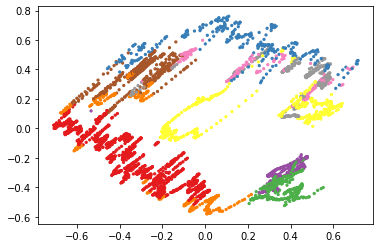

In [20]:
color_map_dict = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'H': 7,
    'I': 8
}

plt.scatter(pca_data[:, 0], pca_data[:, 1], c=primary_data['Cluster'].replace(color_map_dict), cmap='Set1', s=5)
plt.show()

In [21]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.04, min_samples=15).fit(pca_data)
dbscan_label = dbscan.labels_

In [22]:
bcubed_eval(dbscan_label, real_label)
print('-' * 30)
print_entropy(dbscan_label, real_label)

Precision = 0.5962946052511447
Recall = 0.7346352415366451
F-score = 0.6582751636578474
------------------------------
Entropy for cluster -1  =  1.035599685407971
Entropy for cluster 0  =  1.035599685407971
Entropy for cluster 1  =  1.4667088096490817
Entropy for cluster 2  =  0.7119985534477518
Entropy for cluster 3  =  0.4264949244068194
Entropy for cluster 4  =  1.0295022382550307
Entropy for cluster 5  =  0.6365141682948128
Entropy for cluster 6  =  0.0
Entropy for cluster 7  =  0.0
Entropy for cluster 8  =  0.0
Entropy for cluster 9  =  1.2167011542666197
Entropy for cluster 10  =  0.0442600020458068
Total Entropy =  0.5473149613144912


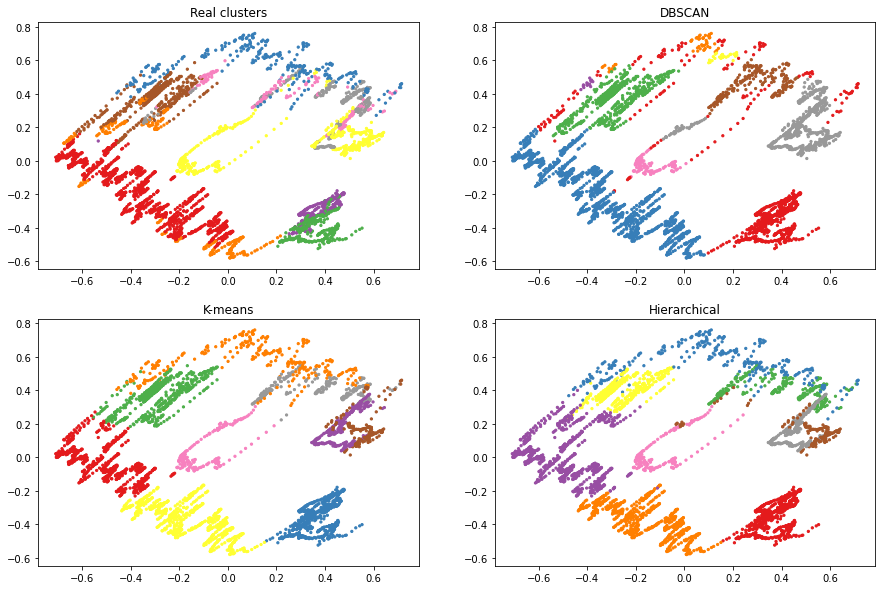

In [23]:
plt.figure(figsize = (15, 10))

plt.subplot(2, 2, 1, title='Real clusters')
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=primary_data['Cluster'].replace(color_map_dict), cmap='Set1', s=5)

plt.subplot(2, 2, 2, title='DBSCAN')
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=dbscan_label, cmap='Set1', s=5)

plt.subplot(2, 2, 3, title='K-means')
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=kmeans_label, cmap='Set1', s=5)

plt.subplot(2, 2, 4, title='Hierarchical')
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=hierarchical_label, cmap='Set1', s=5)

plt.show()